# Preprocessing and reading in train - and test dataset

In [168]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
from datetime import timedelta
import glob
import os
from tqdm import tqdm as tqdm
import time
import seaborn as sns

import geopandas
import geopy
from geopy.geocoders import Nominatim
import folium
from geopy.extra.rate_limiter import RateLimiter
from folium import plugins
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap

%matplotlib inline
import statsmodels.api as sm
from statsmodels.compat import lzip
from statsmodels.formula.api import ols
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

from numpy import cumsum
from datetime import datetime as dt

In [2]:
Train = pd.read_csv(r"C:\Users\20201935\Documents\Data Challenge 2\Stijn data\train_count_street_data.csv")
Train.drop("Unnamed: 0", axis=1, inplace=True)
Train = Train[Train['MSOA'] != 'na']
Train['Crime type'] = Train['Crime type'].replace(['Violent crime'],'Violence and sexual offences')
Train['Crime type'] = Train['Crime type'].replace(['Public disorder and weapons'],'Other crime')
# Train['Crime type'] = Train['Crime type'].replace(['Bicycle theft'],'Other theft')
# Train['Crime type'] = Train['Crime type'].replace(['Theft from the person'],'Other theft')

TestCovid = pd.read_csv(r"C:\Users\20201935\Documents\Data Challenge 2\Stijn data\test_covid_count_street_data.csv")
TestCovid.drop("Unnamed: 0", axis=1, inplace=True)
TestCovid = TestCovid[TestCovid['MSOA'] != 'na']
# TestCovid['Crime type'] = TestCovid['Crime type'].replace(['Bicycle theft'],'Other theft')
# TestCovid['Crime type'] = TestCovid['Crime type'].replace(['Theft from the person'],'Other theft')

TestNoCovid = pd.read_csv(r"C:\Users\20201935\Documents\Data Challenge 2\Stijn data\test_no_covid_count_street_data.csv")
TestNoCovid.drop("Unnamed: 0", axis=1, inplace=True)
TestNoCovid = TestNoCovid[TestNoCovid['MSOA'] != 'na']
# TestNoCovid['Crime type'] = TestNoCovid['Crime type'].replace(['Bicycle theft'],'Other theft')
# TestNoCovid['Crime type'] = TestNoCovid['Crime type'].replace(['Theft from the person'],'Other theft')

# Building a multivariate linear regression model

In [3]:
X_train = Train[['Year', 'Month', 'MSOA', 'Crime type']]
X_train = pd.concat([X_train,pd.get_dummies(X_train['Crime type'])],axis=1)
X_train.drop(['Crime type'],axis=1, inplace=True)

y_train = Train['count']

X_test = TestNoCovid[['Year', 'Month', 'MSOA', 'Crime type']]
X_test = pd.concat([X_test,pd.get_dummies(X_test['Crime type'])],axis=1)
X_test.drop(['Crime type'],axis=1, inplace=True)

y_test = TestNoCovid['count']

# Creating a new model and fitting it
multi_model = LinearRegression()
multi_model.fit(X_train, y_train)

# Prediction new values
predictions = multi_model.predict(X_test)
r2 = r2_score(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)

print('The r2 is: ', r2)
print('The rmse is: ', rmse)

The r2 is:  0.3039075812927974
The rmse is:  699.8621772254907


In [4]:
multi_model.coef_

array([   3.59444183,    1.1092812 ,   -9.28367009,  893.49607535,
       -238.83797482,   33.51500799,   97.97708165, -157.97453406,
       -215.41757867,  101.52531331, -332.50728845,  -82.3271799 ,
       -223.2497863 ,  -41.97718485, -261.10193332,   14.4990842 ,
        412.38089789])

In [5]:
Train['Date'] = Train['Year'].astype(str) + '-' + Train['Month'].astype(str)
TestCovid['Date'] = TestCovid['Year'].astype(str) + '-' + TestCovid['Month'].astype(str)
TestNoCovid['Date'] = TestNoCovid['Year'].astype(str) + '-' + TestNoCovid['Month'].astype(str)

# Arima

In ARIMA_OPTIMAL there has to be the 'd' added as hyperparameter looping. Furthermore, there has to get a bugfix for when optimum returns more than 1 row. (MSE instead of AIC?)

In [146]:
def ARIMA_DATA(df, MSOA, category):
    ###Gets the data of a specific MSOA and category to use in the ARIMA_OPTIMAL function
    ###
    
    df = df[(df['MSOA'] == str(MSOA)) & (df['Crime type'] == category)]
    df = df[['count', 'Date']]
    df = df.set_index('Date')
    
    return df

def ARIMA_STATIONARY(df):
    ###Returns a stationary dataframe, created by ARIMA_DATA
    ###
    if adfuller(df['count'])[1] > 0.05:
        df = df.diff().dropna()
    
    return df

def ARIMA_OPTIMAL(df, MSOA, category):
    ### Looks for the best ARMA(p,q) + constant model according to MSOA and crime type
    ###
    
    order_aic_bic = list()
    
    df = ARIMA_STATIONARY(ARIMA_DATA(df, MSOA, category))

    # Loop over AR order
    for p in range(1,4):
    # Loop over MA order
        for q in range(1,4):
#             for d in range(3):
            try:
            # Fit model
                model = SARIMAX(df, order=(p,0,q), trend='c')
                results = model.fit()
                # Add order and scores to list
                order_aic_bic.append((p, q, results.aic))
            except:
                continue
            
    order_df = pd.DataFrame(order_aic_bic, columns=['p','q','aic'])
    optimum = order_df[order_df['aic'] == order_df['aic'].min()]
    optimum.reset_index(inplace=True)
    return optimum['p'][0], optimum['q'][0], optimum['aic'][0]

def ARIMA_PREDICT(df, MSOA, category):
    ###Forecasts via ARIMA approach
    ###
    
    df2 = ARIMA_STATIONARY(ARIMA_DATA(df, MSOA, category))
    p,q = ARIMA_OPTIMAL(df, MSOA, category)[0:2]
    
    model = SARIMAX(df2, order=(p,0,q), trend='c')
    results = model.fit()
    forecast = results.get_prediction(start=-25)
    mean_forecast = cumsum(forecast.predicted_mean) + df2.iloc[-1,0]
    confidence_intervals = cumsum(forecast.conf_int())
    return mean_forecast, confidence_intervals

def ARIMA_SUMMARY(df, MSOA, category):
    
    df2 = ARIMA_STATIONARY(ARIMA_DATA(df, MSOA, category))
    p,q = ARIMA_OPTIMAL(df, MSOA, category)[0:2]
    
    model = SARIMAX(df2, order=(p,0,q), trend='c')
    results = model.fit()
    
    return results.summary()

In [139]:
print(ARIMA_SUMMARY(Train, '099', 'Burglary'))

                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                   83
Model:               SARIMAX(2, 0, 3)   Log Likelihood                -244.495
Date:                Tue, 29 Mar 2022   AIC                            502.991
Time:                        15:28:39   BIC                            519.922
Sample:                    02-01-2012   HQIC                           509.793
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1219      0.539      0.226      0.821      -0.934       1.178
ar.L1         -1.4240      0.086    -16.646      0.000      -1.592      -1.256
ar.L2         -0.8799      0.069    -12.801      0.0

In [165]:
data = ARIMA_DATA(Train, '099', 'Burglary')
mean_forecasts = ARIMA_PREDICT(Train, '099', 'Burglary')[0].to_frame()
confidence_intervals = ARIMA_PREDICT(Train, '099', 'Burglary')[1]
lower_limits = confidence_intervals['lower count']
upper_limits = confidence_intervals['upper count']

In [182]:
test = mean_forecasts.reset_index()
test['Date'] = test['index'].dt.strftime('%Y-%m')
test.drop(columns=['index'], inplace=True, axis=1)
test.set_index('Date', inplace=True)
test

,predicted_mean
Date,
2016-12,-9.525054
2017-01,-7.815584
2017-02,-7.694856
2017-03,-11.033892
2017-04,-6.159174
2017-05,-11.425991
2017-06,-11.237037
2017-07,-5.211877
2017-08,-6.263442


In [177]:
data

,count
Date,
2012-1,19
2012-2,12
2012-3,15
2012-4,25
2012-5,8
...,...
2018-8,20
2018-9,17
2018-10,22


<AxesSubplot:xlabel='Date'>

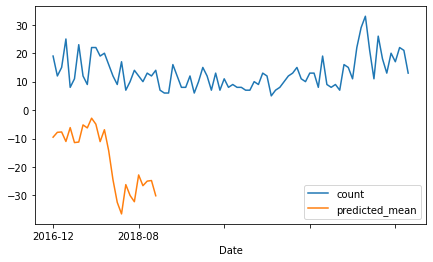

In [183]:
fig = data.plot(figsize=(7,4))
fig2 = test.plot(ax=fig)
# fig2.legend(['count', 'forecasted']);
fig

<AxesSubplot:xlabel='Date'>

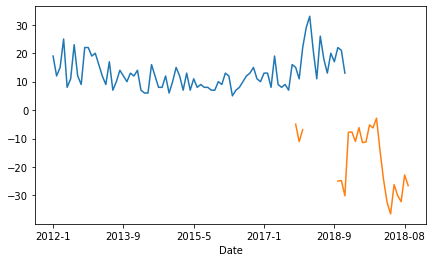

In [186]:
plot_data = pd.concat([data, test], axis=1)
fig_plot = plot_data['count'].plot(figsize=(7,4))
fig_plot_2 = plot_data['predicted_mean'].plot(ax=fig_plot)
# fig2.legend(['count', 'forecasted']);
fig_plot_2

In [46]:
Train['Crime type'].unique()

array(['Anti-social behaviour', 'Burglary', 'Criminal damage and arson',
       'Drugs', 'Other crime', 'Other theft', 'Robbery', 'Shoplifting',
       'Vehicle crime', 'Violence and sexual offences', 'Bicycle theft',
       'Possession of weapons', 'Public order', 'Theft from the person'],
      dtype=object)